In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from numba import njit

In [2]:
sim_list = ['fRpoly-Rcore1.0-DesNumNgbEnrichment32', 'fRpoly-Rcore1.0', 'fRpoly-Rcore1.0-DesNumNgbEnrichment128', 'fRpoly-Rcore1.0-DesNumNgbEnrichment512']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

In [3]:
sfr_32 = read_sfr(0, lvl='lvl3')
sfr_64 = read_sfr(1, lvl='lvl3')
sfr_128 = read_sfr(2, lvl='lvl3')
sfr_512 = read_sfr(3, lvl='lvl3')

In [4]:
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

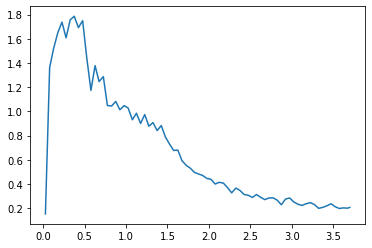

In [5]:
t, SFR = binned_average(sfr_64[:,0], sfr_64[:,2], 0.05)
plt.plot(t, SFR)
plt.show()

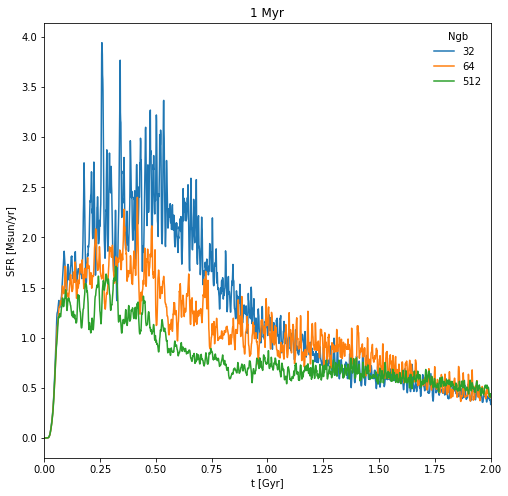

In [7]:
window = 1000

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.001

t, SFR = binned_average(sfr_32[:,0], sfr_32[:,2], dt)
ax.plot(t, SFR, label='32')

t, SFR = binned_average(sfr_64[:,0], sfr_64[:,2], dt)
ax.plot(t, SFR, label='64')

t, SFR = binned_average(sfr_128[:,0], sfr_128[:,2], dt)
# ax.plot(t, SFR, label='128')

t, SFR = binned_average(sfr_512[:,0], sfr_512[:,2], dt)
ax.plot(t, SFR, label='512')

ax.legend(frameon=False, title='Ngb')
ax.set(xlabel='t [Gyr]', ylabel='SFR [Msun/yr]')
ax.set_xlim(0, 2)
ax.set_title('1 Myr')
plt.show()

array([0.000000e+00, 3.814697e-06, 7.629395e-06, ..., 5.297852e-02,
       5.299377e-02, 5.300903e-02])

In [16]:
def get_n_T(rho, u, xe, XH=0.76):
    GAMMA = 5./3.
    BOLTZMANN = 1.38065e-16
    PROTONMASS = 1.67262178e-24
    UnitLength_in_cm = 3.08568e+21
    UnitMass_in_g = 1.989e+43
    UnitVelocity_in_cm_per_s = 100000
    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitEnergy_in_cgs = UnitMass_in_g * UnitLength_in_cm**2 / (UnitTime_in_s**2)
    
    mu = (4 * PROTONMASS) / (1. + 3*XH + 4 * XH * xe)
    T = (GAMMA - 1.) * (u/BOLTZMANN) * (UnitEnergy_in_cgs/UnitMass_in_g) * mu
    
    n = UnitMass_in_g * rho / mu # in kpc^-3
    n *= UnitLength_in_cm**(-3.)
    
    return n, T

sn_32 = read_snap(100, 0, lvl='lvl3', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance', 'Density'])
n_32, T_32 = get_n_T(sn_32.part0.rho, sn_32.part0.u, sn_32.part0.ne)

sn_64 = read_snap(100, 1, lvl='lvl3', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance', 'Density'])
n_64, T_64 = get_n_T(sn_64.part0.rho, sn_64.part0.u, sn_64.part0.ne)

sn_128 = read_snap(100, 2, lvl='lvl3', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance', 'Density'])
n_128, T_128 = get_n_T(sn_128.part0.rho, sn_128.part0.u, sn_128.part0.ne)

sn_512 = read_snap(100, 3, lvl='lvl3', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance', 'Density'])
n_512, T_512 = get_n_T(sn_512.part0.rho, sn_512.part0.u, sn_512.part0.ne)

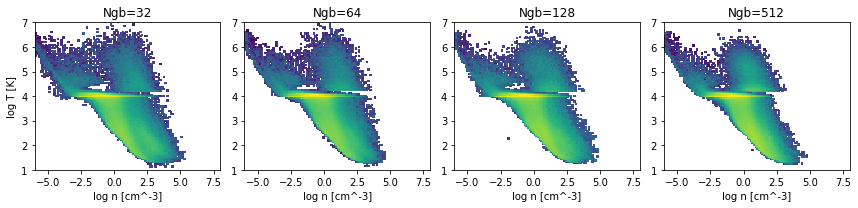

In [19]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,4, figsize=(12, 3))

ax[0].hist2d(np.array(np.log10(n_32)), np.array(np.log10(T_32)), bins=100, weights=sn_32.part0.mass, norm=LogNorm())
ax[1].hist2d(np.array(np.log10(n_64)), np.array(np.log10(T_64)), bins=100, weights=sn_64.part0.mass, norm=LogNorm())
ax[2].hist2d(np.array(np.log10(n_128)), np.array(np.log10(T_128)), bins=100, weights=sn_128.part0.mass, norm=LogNorm())
ax[3].hist2d(np.array(np.log10(n_512)), np.array(np.log10(T_512)), bins=100, weights=sn_512.part0.mass, norm=LogNorm())

ax[0].set(xlim=(-6, 8), ylim=(1, 7), xlabel='log n [cm^-3]', ylabel='log T [K]', title='Ngb=32')
ax[1].set(xlim=(-6, 8), ylim=(1, 7), xlabel='log n [cm^-3]', title='Ngb=64')
ax[2].set(xlim=(-6, 8), ylim=(1, 7), xlabel='log n [cm^-3]', title='Ngb=128')
ax[3].set(xlim=(-6, 8), ylim=(1, 7), xlabel='log n [cm^-3]', title='Ngb=512')

fig.tight_layout()

plt.show()